## Hierarchical clustering

### Importing libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import copy
import time

### Preprocessing the Data

In [4]:
df = pd.read_csv('football_data.csv').set_index('Unnamed: 0')

df_1=df[df['Position'].isna()==False]
df_1.loc[:,'Weight'] = df_1['Weight'].apply(lambda x: float(str(x).split('lbs')[0]) )

df_1.loc[:,'LS':'RB'] = df_1.loc[:,'LS':'RB'].fillna('0+0')

df_2 = df_1[df_1['Height'].isna()==False]

df_2.loc[:,'Height'] = df_2['Height'].apply(lambda x: float(str(x).split('\'')[0])*12 + float(str(x).split('\'')[1])  )

cols_pos = list(df_2.loc[:,'LS':'RB'].columns)

for col in cols_pos:
    df_2.loc[:,col] = df_2[col].apply(lambda x: float(str(x).split('+')[0]) + float(str(x).split('+')[1]) )
    
df=df_2


### Selecting the numeric values from the dataset

In [5]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
scaler = MinMaxScaler()
newdf = df.select_dtypes(include=numerics)

newdf.insert(0, "Name", list(df.Name), True)
newdf = newdf.drop(columns = ['ID','Jersey Number'])

### Scaling the data using MinMaxScaler

In [6]:
X = scaler.fit_transform(newdf.iloc[:,1:])
y = np.array(newdf.iloc[:,0])

### Agglomerative Clustering

### Plotting Dendrogram for Agglomerative Clustering

**We have used Average Linkage in order to perform agglomerative clusters**

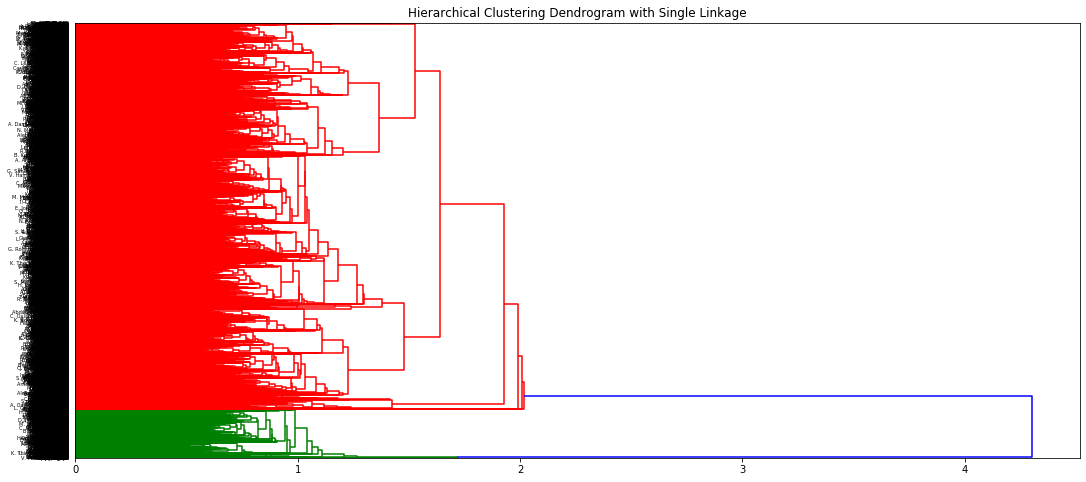

In [8]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(18,8))
plt.title('Hierarchical Clustering Dendrogram with Single Linkage')
samples =len(X)
dendrogram = sch.dendrogram(sch.linkage(X[:samples], method="average"), labels= y[:samples], orientation='right')
plt.savefig('dendro(agglomerative).png')

### Analysis of the clusters formed

In [43]:
cluster_0 = []
for name in dendrogram['ivl'][:2024]:
    cluster_0.append(str(df.loc[df.Name == name,'Position'].to_numpy()[0]))

In [42]:
cluster_1 = []
for name in dendrogram['ivl'][2024:]:
    cluster_1.append(str(df.loc[df.Name == name,'Position'].to_numpy()[0]))

**We divided the clusters based on the color-list returned by the dendrogram**

- Cluster Green contains mainly of goalkeepers
- Cluster Red contains players other than goalkeepers

In [51]:
from collections import Counter

print('Cluster Color Green',sorted(Counter(cluster_0).items(), key=lambda x: x[1], reverse=True)[:5])
print('Cluster Color Red',sorted(Counter(cluster_1).items(), key=lambda x: x[1], reverse=True)[:5])

Cluster Color Green [('GK', 1918), ('ST', 16), ('CB', 12), ('CDM', 9), ('RB', 8)]
Cluster Color Red [('ST', 2127), ('CB', 1726), ('CM', 1368), ('LB', 1298), ('RB', 1280)]


### Code for Divisive Clustering 

In [52]:
class DivisiveClustering:
	'''
	Class which implements the DIANA (Divisive Analysis) algorithm and provides an interface for using the implementation.
	'''
	def __init__(self):
		'''
		Initializer for the DivisiveClustering class.
		This function initializes some important class variables.
		'''
		self.clusters={}
		self.dist_matrix=None
		self.mapping=None
		self.no_clusters=0
		self.linkage_matrix=None
		self.n=None
		self.hierarchical_clusters={}
		self.last_index=None

	def initialize(self):
		'''
		Initializer for the DivisiveClustering class.
		Parameters
		----------
		path : string
		    path to file containinng transactions.
		
		Returns
		----------
		transactions : list
			list containing all transactions. Each transaction is a list of
			items present in that transaction.
		items : list
			list containing all the unique items.
		'''
		self.n=len(self.mapping)
		self.last_index=2*self.n-2
		self.i=0
		self.clusters[self.last_index]=list(self.mapping.keys())
		self.linkage_matrix=np.zeros([self.n-1, 4])

	def splinter(self):
		'''
		This function finds the cluster with the largest diameter and finds the splinter element.
		Returns
		----------
		splinter_element : int
			the splinter element. This element will be removed from the cluster that is being split.
		max_diameter_cluster : int
			index of the cluster with the largest diameter. This is the cluster which will be split.
		'''
		cluster_diameters={k:(len(v)<1)*(-1)+(len(v)>1)*np.max(self.dist_matrix[np.ix_(v,v)]) for k,v in self.clusters.items()}
		max_diameter_cluster=max(cluster_diameters, key=cluster_diameters.get)
		avg_within_cluster_distances={pt:(np.sum(self.dist_matrix[np.ix_(self.clusters[max_diameter_cluster], [pt])])/(len(self.clusters[max_diameter_cluster])-1)) for pt in self.clusters[max_diameter_cluster]}
		splinter_element=max(avg_within_cluster_distances, key=avg_within_cluster_distances.get)
		self.no_clusters+=1
		return splinter_element, max_diameter_cluster

	def reassign(self, splinter_element, orig_cluster_key):
		'''
		Function which reassigns points between the original cluster and the splinter cluster.
		Parameters
		----------
		splinter_element : int
		    the splinter element.
		orig_cluster_key : int
		    the ID of the element to be split.
		'''
		# Create temp clusters
		temp_new_cluster=[splinter_element]
		self.clusters[orig_cluster_key].remove(splinter_element)
		temp_orig_cluster=self.clusters[orig_cluster_key]

		# Remove orig cluster from cluster dict
		del self.clusters[orig_cluster_key]

		# Calculate distances
		within_cluster_dist={pt:np.mean(self.dist_matrix[np.ix_(temp_orig_cluster,[pt])]) for pt in temp_orig_cluster }
		dist_to_splinter={pt:self.dist_matrix[pt, splinter_element]  for pt in temp_orig_cluster}
		dist_diff={pt:(within_cluster_dist[pt] - dist_to_splinter[pt]) for pt in temp_orig_cluster} # if +ve, move to splinter
		
		# Reassign points
		for pt in temp_orig_cluster:
			if dist_diff[pt]>0 and len(temp_orig_cluster)>1:
				temp_new_cluster.append(pt)
				temp_orig_cluster.remove(pt)
		
		dist_bw_clusters=np.max(self.dist_matrix[np.ix_(temp_orig_cluster, temp_new_cluster)])
		
		# Add temp clusters to cluster dict
		if len(temp_orig_cluster)==1:
			self.clusters[temp_orig_cluster[0]]=temp_orig_cluster
			orig_cluster_key=temp_orig_cluster[0]
		else:
			self.last_index-=1
			self.clusters[self.last_index]=temp_orig_cluster
			orig_cluster_key=self.last_index

		if len(temp_new_cluster)==1:
			self.clusters[temp_new_cluster[0]]=temp_new_cluster
			new_cluster_key=temp_new_cluster[0]
		else:
			self.last_index-=1
			self.clusters[self.last_index]=temp_new_cluster
			new_cluster_key=self.last_index

		# Append to hierarchical clusters
		self.hierarchical_clusters['iter_'+str(self.no_clusters)]=copy.deepcopy(self.clusters)

		# Make the linkage function
		self.make_linkage_function(new_cluster_key, orig_cluster_key, dist_bw_clusters, len(temp_new_cluster)+len(temp_orig_cluster))

	def make_linkage_function(self, cluster_1, cluster_2, dist, len_cluster_2):
		'''
		Function to create the linakge matrix 'Z' for the dendrogram.
		Parameters
		----------
		cluster_1 : int
		    the ID of the first cluster.
		cluster_2 : string
		    the ID of the first cluster.
		dist : string
		    distance between the newly formed clusters.
		len_cluster_2 : string
		    number of elements in the original cluster which was later split.
		'''
		self.linkage_matrix[self.n-self.no_clusters-1, 0]=cluster_2
		self.linkage_matrix[self.n-self.no_clusters-1, 1]=cluster_1
		self.linkage_matrix[self.n-self.no_clusters-1, 2]=dist
		self.linkage_matrix[self.n-self.no_clusters-1, 3]=len_cluster_2

	def termination(self):
		'''
		Function to check whether clustering has termianted.
		Clustering has terminated when there's only one element in all of the clusters.
		Returns
		----------
		terminated : int (0 or 1)
			function returns 1 on termination. 0 otherwise.
		'''
		for k, v in self.clusters.items():
			if len(v)>1:
				return 0
		return 1

	def fit(self, dist_matrix, mapping):
		'''
		Function that fits the data on the HierarchicalCLustering model.
		Parameters
		----------
		dist_matrix : numpy ndarray
		    the distance matrix.
		mapping : dict
		    mapping of the cluster ids to original names from dataset.
		'''
		self.dist_matrix=dist_matrix
		self.mapping=mapping
		self.initialize()
		start = time.time()
		while not self.termination():
			splinter_element, orig_cluster_key=self.splinter()
			self.reassign(splinter_element, orig_cluster_key)
		end = time.time()
# 		print("Time Taken = ",end-start)
            
# 		print('Clustering done!')

	def create_dendrogram(self):
		'''
		Function to create the dendrogram using the linakge matrix and save it to file.
		'''
		fig=plt.figure(figsize=(18, 8))
		plt.title("Dendrogram - Divisive Clustering")
		labels=['temp']*len(self.mapping)
		for idx,label in self.mapping.items():
			labels[idx]=label
		labels=np.array(labels)
		self.dend = hierarchy.dendrogram(self.linkage_matrix, orientation='right', labels=labels)
		fig.savefig('dendrogram_divisive.png')
		plt.show()


### Calculating the distance matrix for each point in order to perform divisive clustering

**We have used 1000 samples of data beacuse of the following reasons:-**

- For clear representation of dendrograms
- To decrease computation as it was taking a huge time to process the whole data 

In [9]:
samples =1000
mapping={ind:k for ind, k in enumerate(y[:samples])}

dist_matrix = np.zeros((samples,samples))

for row in range(samples):
    dist_matrix[row][:] = np.sqrt(np.sum(X[:samples]-X[row],axis=1)**2)


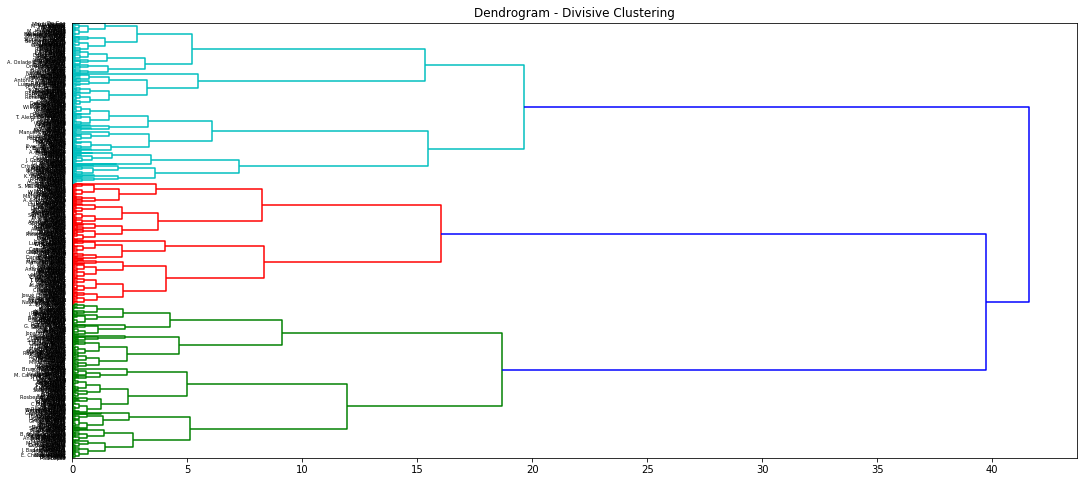

In [53]:
model=DivisiveClustering()
model.fit(dist_matrix, mapping)
model.create_dendrogram()

**In divisive clustering, it starts with the whole dataset as a single cluster and then divides down the data till you get all the singleton clusters.**

**Over here in order to divide a cluster we find the cluster with the maximum diameter and then perform division of that cluster using a Splinter element.**

**Splinter element in the cluster is the element having the maximum average distance to the rest of the points.**

### Analysis of clusters

In [63]:
cluster_0 = []
for name in model.dend['ivl'][:353]:
    cluster_0.append(str(df.loc[df.Name == name,'Position'].to_numpy()[0]))

In [64]:
cluster_1 = []
for name in model.dend['ivl'][353:628]:
    cluster_1.append(str(df.loc[df.Name == name,'Position'].to_numpy()[0]))

In [65]:
cluster_2 = []
for name in model.dend['ivl'][628:]:
    cluster_2.append(str(df.loc[df.Name == name,'Position'].to_numpy()[0]))

**From the below result, we can see that the clusters formed are not satisfactory as the three clusters formed contains similar kind of clusters**

**This leads to a higher inter class similarity than intra class similarity**

In [66]:
print('Cluster Color Green',sorted(Counter(cluster_0).items(), key=lambda x: x[1], reverse=True)[:5])
print('Cluster Color Red',sorted(Counter(cluster_1).items(), key=lambda x: x[1], reverse=True)[:5])
print('Cluster Color Blue',sorted(Counter(cluster_2).items(), key=lambda x: x[1], reverse=True)[:5])

Cluster Color Green [('GK', 39), ('ST', 32), ('RM', 25), ('CM', 22), ('CAM', 21)]
Cluster Color Red [('GK', 32), ('CAM', 28), ('CB', 21), ('ST', 19), ('LB', 15)]
Cluster Color Blue [('GK', 38), ('ST', 35), ('LM', 29), ('CM', 27), ('CB', 25)]


**Thus, we can conclude that Agglomerative clustering for this data is better than divisive clustering.**